# Interview Question:
## Tomorrow’s Rain Forecast for New York<br>
The Historical Hourly Weather Data 2012-2017 on Kaggle contains 5 years of hourly measurements of various weather attributes, such as temperature, humidity, air pressure, etc. The data are available to download from Kaggle at the following link:<br>
https://www.kaggle.com/selfishgene/historical-hourly-weather-data<br>
### Task: 
<br>Given historical weather data, can you predict whether tomorrow will be rainy in New York? Any weather description that is a form of liquid precipitation is considered rainy, such as those containing keywords “rain”, “thunderstorm”, “drizzle”, etc. You have flexibility in defining “rainy" and “tomorrow” (e.g. next 24 hours from current hour); no matter what your definitions are, please make them clear in the report.
In the open-ended quiz, please make sure you address the following questions:
- Define metrics to evaluate algorithm performance
- What are your training, validation, and testing sets?
- Implement a simple baseline
- Compare the performance of one more algorithm to the baseline
- At least one algorithm should use a machine-learning/deep-learning approach

### Tina's Comments:<br>
This version of notebook is my first trial. In this trial, I will upsample the weather information from hourly to daily. And then use the historical daily weather data to forecast the next day.The target would be a binary forecast (Rain: 0 or 1) for the next 24 hours. <br>
Note in the dataset, a day starts @ 12pm in the middle of the day. But I will split "today" and "tomorrow" by wall clock midnight and delete the extra info. <br>
I'm going to stick with the definition of rainy in the problem statement, any weather contains "rain", "thunderstorm", or "drizzle" is considered as rainy.
<br>
This is a Multivariate Time Series prediction problem. <br>
I will approach this problem with a traditional stats model VAR first. Then use sequence models and frame this as a supervised learning problem.

In [300]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow.keras.layers import Dense, LSTM, Bidirectional, Flatten, TimeDistributed, Conv1D, MaxPool1D
from itertools import product
from math import sqrt
from warnings import catch_warnings
from warnings import filterwarnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
import seaborn as sns
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
%matplotlib inline

In [301]:
def extract_new_york_info(data_file,column_name,city):
    df=pd.read_csv(data_file)
    ny_df=df[['datetime',city]]
    ny_df.rename(columns={city:column_name}, inplace=True)
    ny_df.set_index('datetime',inplace=True)
    return ny_df

In [302]:
def create_city_dataset(dataset_dir, city):
    data_files = os.listdir(dataset_dir)
    if 'city_attributes.csv' in data_files: data_files.remove('city_attributes.csv') # do not need it for now
    column_names = [x.replace('.csv','') for x in data_files]
#     print(column_names)
    dfs=[]
    for i in range(len(data_files)):
        df = extract_new_york_info(os.path.join(dataset_dir,data_files[i]),column_names[i],city)
        dfs.append(df)
#     print(len(dfs))
    ny_df = pd.concat(dfs, axis=1) # We are lucky here because dataset has no missing datetime index across files
    return ny_df

In [303]:
def is_rainny(value):
    keywords = ['rain','thunderstorm', 'drizzle'] # will label all instances containing these keywords as "rain", otherwise "no rain"
    rainny=0
    for x in keywords:
        if x in value:
            return 1
    return 0

In [304]:
def plot_roc(y,y_pred,name):
    fpr, tpr, threshold = metrics.roc_curve(y, y_pred)
    roc_auc = metrics.auc(fpr, tpr)

    fig, ax = plt.subplots(1, figsize=(12, 6))
    plt.plot(fpr, tpr, color='darkorange', label = 'AUC = %0.2f' % roc_auc)
    plt.plot([0, 1], [0, 1], color='gray', label='Random Performace')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Seattle Rain ROC Curve {}'.format(name))
    plt.legend(loc="lower right")

In [305]:
dataset_dir = 'historical-hourly-weather-data'
city='New York'
ny_df = create_city_dataset(dataset_dir, city)
ny_df.head()

/usr/local/lib/python3.6/site-packages/pandas/core/frame.py:3027: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  return super(DataFrame, self).rename(**kwargs)


,weather_description,humidity,wind_direction,temperature,pressure,wind_speed
datetime,,,,,,
2012-10-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN
2012-10-01 13:00:00,few clouds,58.0,260.0,288.220000,1012.0,7.0
2012-10-01 14:00:00,few clouds,57.0,260.0,288.247676,1012.0,7.0
2012-10-01 15:00:00,few clouds,57.0,260.0,288.326940,1012.0,7.0
2012-10-01 16:00:00,few clouds,57.0,260.0,288.406203,1012.0,7.0


In [306]:
# check if there is any invalid field in the dataset
ny_df.isnull().sum()

weather_description     793
humidity               1624
wind_direction          793
temperature             793
pressure               1041
wind_speed              793
dtype: int64

In [307]:
# Fill in missing values
ny_df['weather_description'].fillna('None', axis=0, inplace=True)
ny_df.fillna(method='ffill', axis=0, inplace=True)
ny_df.fillna(method='bfill', axis=0, inplace=True)
ny_df.isnull().sum()

weather_description    0
humidity               0
wind_direction         0
temperature            0
pressure               0
wind_speed             0
dtype: int64

In [308]:
ny_df['rainny']=ny_df['weather_description'].apply(is_rainny)
ny_df.head()

,weather_description,humidity,wind_direction,temperature,pressure,wind_speed,rainny
datetime,,,,,,,
2012-10-01 12:00:00,None,58.0,260.0,288.220000,1012.0,7.0,0
2012-10-01 13:00:00,few clouds,58.0,260.0,288.220000,1012.0,7.0,0
2012-10-01 14:00:00,few clouds,57.0,260.0,288.247676,1012.0,7.0,0
2012-10-01 15:00:00,few clouds,57.0,260.0,288.326940,1012.0,7.0,0
2012-10-01 16:00:00,few clouds,57.0,260.0,288.406203,1012.0,7.0,0


In [326]:
# downsample the data
target_df=ny_df['2012-10-02':]
# target_df.drop('weather_description',inplace=True)
target_df['date']=pd.DatetimeIndex(target_df.index).date
target_df['month']=pd.DatetimeIndex(target_df.index).month
target_df['day']=pd.DatetimeIndex(target_df.index).day
target_df.head()

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-d

,weather_description,humidity,wind_direction,temperature,pressure,wind_speed,rainny,date,month,day
datetime,,,,,,,,,,
2012-10-02 00:00:00,few clouds,55.0,264.0,289.040311,1012.0,6.0,0,2012-10-02,10,2
2012-10-02 01:00:00,few clouds,54.0,264.0,289.119575,1012.0,6.0,0,2012-10-02,10,2
2012-10-02 02:00:00,few clouds,54.0,265.0,289.198838,1012.0,6.0,0,2012-10-02,10,2
2012-10-02 03:00:00,few clouds,54.0,265.0,289.278102,1012.0,6.0,0,2012-10-02,10,2
2012-10-02 04:00:00,few clouds,53.0,265.0,289.357365,1012.0,6.0,0,2012-10-02,10,2


In [327]:
# new_df_max=target_df[['humidity','wind_direction','temperature','pressure','wind_speed','date','month','day']].groupby('date').apply(max)
# titles={'humidity':'humidity_max',
#         'wind_direction':'wind_direction_max',
#         'temperature':'temperature_max',
#         'pressure':'pressure_max',
#         'wind_speed':'wind_speed_max'
#        }
# new_df_max.rename(columns=titles, inplace=True)
# new_df_max.head()

In [328]:
# new_df_min=target_df[['humidity','wind_direction','temperature','pressure','wind_speed','date','month','day']].groupby('date').min()
# titles={'humidity':'humidity_min',
#         'wind_direction':'wind_direction_min',
#         'temperature':'temperature_min',
#         'pressure':'pressure_min',
#         'wind_speed':'wind_speed_min'
#        }
# new_df_min.rename(columns=titles, inplace=True)
# new_df_min.head()

In [329]:
new_df_rain_label=target_df[['rainny','date']].groupby('date').sum()
new_df_rain_label['label']=new_df_rain_label['rainny'].apply(lambda x: 1 if x>0 else 0)
new_df_rain_label.rename(columns={'rainny':'rain_count'},inplace=True)
new_df_rain_label.head()

,rain_count,label
date,,
2012-10-02,0,0
2012-10-03,3,1
2012-10-04,5,1
2012-10-05,7,1
2012-10-06,0,0


In [316]:
downsampled_df= pd.concat([new_df_max,new_df_min,new_df_rain_label], axis=1)
downsampled_df.head()

,humidity_max,wind_direction_max,temperature_max,pressure_max,wind_speed_max,date,month,day,humidity_min,wind_direction_min,temperature_min,pressure_min,wind_speed_min,month,day,rain_count,label
date,,,,,,,,,,,,,,,,,
2012-10-02,55.0,303.0,294.85,1013.0,6.0,2012-10-02,10,2,43.0,240.0,289.040311,1011.0,1.0,10,2,0,0
2012-10-03,100.0,330.0,292.88,1017.0,5.0,2012-10-03,10,3,46.0,0.0,288.540000,1014.0,0.0,10,3,3,1
2012-10-04,100.0,340.0,295.27,1018.0,3.0,2012-10-04,10,4,83.0,0.0,290.120000,1015.0,0.0,10,4,5,1
2012-10-05,100.0,170.0,296.27,1020.0,4.0,2012-10-05,10,5,78.0,0.0,291.580000,1017.0,0.0,10,5,7,1
2012-10-06,100.0,320.0,299.78,1018.0,4.0,2012-10-06,10,6,39.0,0.0,287.780000,1014.0,0.0,10,6,0,0


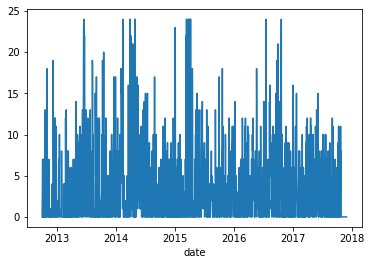

In [319]:
downsampled_df['rain_count'].plot()

In [165]:
interested_features=['humidity_max', 'temperature_max', 'wind_direction_max', 'wind_speed_max', 'pressure_max','humidity_min', 'temperature_min', 'wind_direction_min', 'wind_speed_min', 'pressure_min','month','day','rain_count','label']
# interested_features=['humidity_max', 'temperature_max', 'wind_direction_max', 'wind_speed_max', 'pressure_max', 'month','rain_count']
X = downsampled_df[interested_features].values
y = downsampled_df[['label']].values
X = X[:-1]
y = y[1:] # target is label one timestep in the future
print(X.shape,y.shape)

(1885, 16) (1885, 1)


In [166]:
# use first 4 years as training and last year as test set
X_scaled = preprocessing.scale(X)
X_train, X_test = X_scaled[:len(X)-365],X_scaled[len(X)-365:]
y_train, y_test = y[:len(X)-365],y[len(X)-365:]

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Accuracy: 0.6; Precision: 0.6049382716049383; Recall: 0.7461928934010152
[[ 72  96]
 [ 50 147]]


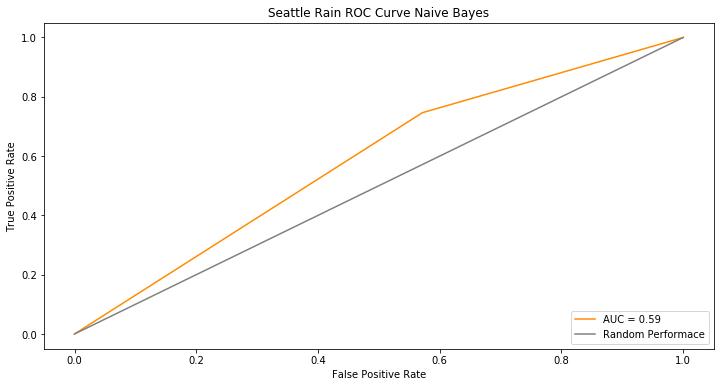

In [167]:
from sklearn.naive_bayes import GaussianNB
# Assume the likelihood of the features is Gaussian
from sklearn import metrics

naive = GaussianNB()
naive.fit(X_train,y_train)
y_predicted_nb = naive.predict(X_test)
acc = metrics.accuracy_score(y_test,y_predicted_nb)
precision_score = metrics.precision_score(y_test,y_predicted_nb)
recall_score = metrics.recall_score(y_test,y_predicted_nb)
print('Accuracy: {}; Precision: {}; Recall: {}'.format(acc,precision_score,recall_score))
print(metrics.confusion_matrix(y_test,y_predicted_nb))
plot_roc(y_test,y_predicted_nb,'Naive Bayes')

/usr/local/lib/python3.6/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:3: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  This is separate from the ipykernel package so we can avoid doing imports until


Accuracy: 0.6575342465753424; Precision: 0.6730769230769231; Recall: 0.7106598984771574
[[100  68]
 [ 57 140]]


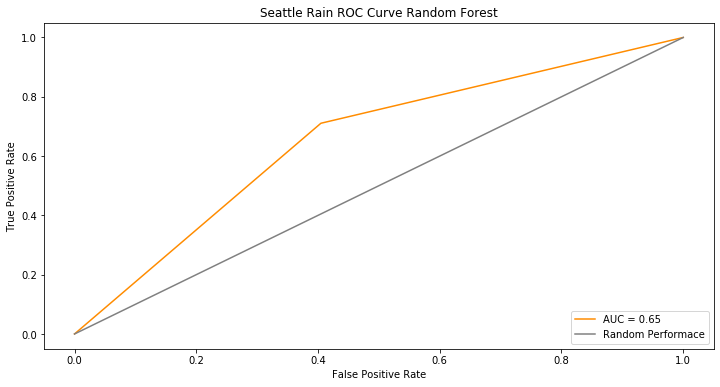

In [168]:
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier()
rfc.fit(X_train,y_train)
y_predicted_rfc = rfc.predict(X_test)
acc = metrics.accuracy_score(y_test,y_predicted_rfc)
precision_score = metrics.precision_score(y_test,y_predicted_rfc)
recall_score = metrics.recall_score(y_test,y_predicted_rfc)
print('Accuracy: {}; Precision: {}; Recall: {}'.format(acc,precision_score,recall_score))
print(metrics.confusion_matrix(y_test,y_predicted_rfc))
plot_roc(y_test,y_predicted_rfc,'Random Forest')

/usr/local/lib/python3.6/site-packages/sklearn/utils/validation.py:724: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy: 0.6465753424657534; Precision: 0.6317829457364341; Recall: 0.8274111675126904
[[ 73  95]
 [ 34 163]]


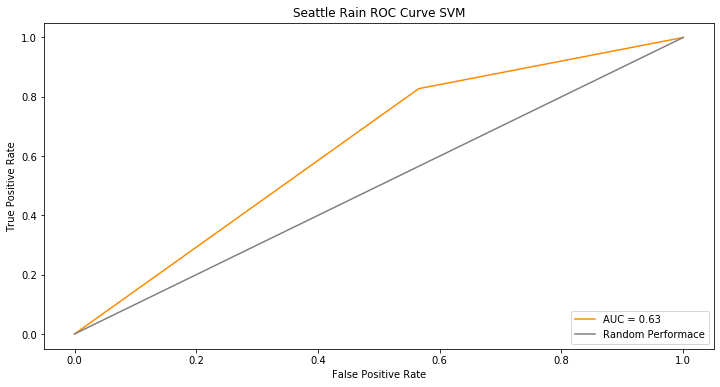

In [170]:
from sklearn.svm import SVC, LinearSVC
svc = SVC()
svc.fit(X_train,y_train)
y_predicted_svc = svc.predict(X_test)
acc = metrics.accuracy_score(y_test,y_predicted_svc)
precision_score = metrics.precision_score(y_test,y_predicted_svc)
recall_score = metrics.recall_score(y_test,y_predicted_svc)
print('Accuracy: {}; Precision: {}; Recall: {}'.format(acc,precision_score,recall_score))
print(metrics.confusion_matrix(y_test,y_predicted_svc))
plot_roc(y_test,y_predicted_svc,'SVM')

In [82]:
def plot_loss_history(history, start=None, end=None):
    if start == None: start=1
    if end == None: end=len(history.history['loss'])
    assert start<end
    assert end<=len(history.history['loss'])
    # Get training and test loss histories
    training_loss = history.history['loss'][start:end]
    test_loss = history.history['val_loss'][start:end]

    # Create count of the number of epochs
    epoch_count = range(start, end)

    # Visualize loss history
    plt.plot(epoch_count, training_loss, 'r--')
    plt.plot(epoch_count, test_loss, 'b-')
    plt.legend(['Training Loss', 'Validation Loss'])
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show();

In [80]:
def scale_features(start, end, source, target):
#     print(target.shape)
    feature_min = np.min(source[start:end], axis=0)
    feature_max = np.max(source[start:end], axis=0)
    denom_factor=np.subtract(feature_max,feature_min)
#     print(feature_max)
#     print(feature_min)
#     print(denom_factor)
    results = np.array([np.divide(np.subtract(x,feature_min),denom_factor) for x in target])
#     print(results.shape)
    return results
# scale_features(34049, 34049+6009, X, Xval)

In [77]:
# generated windowed sequence inputs with [# timestep, # features]
def generate_sequence_data(ts_x, ts_y, window_size):
    inputs=[]
    outputs=[]
    for i in range(len(ts_x)-window_size):
        sample=ts_x[i:i+window_size]
        gt=ts_y[i+window_size-1]
        inputs.append(sample)
        outputs.append(gt)
    return np.array(inputs), np.array(outputs)

In [171]:
input_step=7 # past N days as input
output_step=1 # next day
sequence_inputs,sequence_labels = generate_sequence_data(X,y,input_step)
print(sequence_inputs.shape)
print(sequence_labels.shape)

(1878, 7, 16)
(1878, 1)


In [172]:
train=0.6
val=0.2
test=0.2
train_idx=int(train*len(sequence_inputs))
val_idx=int((train+val)*len(sequence_inputs))
Xtrain, Xval, Xtest = sequence_inputs[:train_idx],sequence_inputs[train_idx:val_idx],sequence_inputs[val_idx:]
ytrain, yval, ytest = sequence_labels[:train_idx],sequence_labels[train_idx:val_idx],sequence_labels[val_idx:]
print(Xtrain.shape)
print(ytrain.shape)
print(Xval.shape)
print(yval.shape)
print(Xtest.shape)
print(ytest.shape)

(1126, 7, 16)
(1126, 1)
(376, 7, 16)
(376, 1)
(376, 7, 16)
(376, 1)


In [173]:
Xtrain_scaled = scale_features(0, Xtrain.shape[0], X, Xtrain)
Xval_scaled = scale_features(Xtrain.shape[0], Xtrain.shape[0]+Xval.shape[0], X, Xval)
Xtest_scaled = scale_features(Xtrain.shape[0]+Xval.shape[0], len(X), X, Xtest)

### Method 1: vanilla LSTM

In [174]:
# Build vanilla LSTM model
lstm_model = tf.keras.Sequential()
lstm_model.add(LSTM(20, activation='relu', input_shape=(Xtrain_scaled.shape[1], Xtrain_scaled.shape[2])))
lstm_model.add(Dense(1, activation='sigmoid'))
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_12 (LSTM)               (None, 20)                2960      
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 21        
Total params: 2,981
Trainable params: 2,981
Non-trainable params: 0
_________________________________________________________________


In [175]:
saved_model_path=os.path.join(os.getcwd(),'LSTM.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_model_path,
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True,
        verbose=1
    )

In [176]:
lstm_history = lstm_model.fit(Xtrain_scaled,ytrain, epochs=50, validation_data=(Xval_scaled,yval), shuffle=True, callbacks=[model_checkpoint_callback])

Train on 1126 samples, validate on 376 samples
Epoch 1/50
 800/1126 [====================>.........] - ETA: 0s - loss: 0.6734 - accuracy: 0.5863
Epoch 00001: val_loss improved from inf to 0.64287, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/LSTM.hdf5
1126/1126 [==============================] - 1s 1ms/sample - loss: 0.6723 - accuracy: 0.5835 - val_loss: 0.6429 - val_accuracy: 0.6330
Epoch 2/50
 800/1126 [====================>.........] - ETA: 0s - loss: 0.6642 - accuracy: 0.5700
Epoch 00002: val_loss improved from 0.64287 to 0.62119, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/LSTM.hdf5
1126/1126 [==============================] - 0s 160us/sample - loss: 0.6568 - accuracy: 0.5861 - val_loss: 0.6212 - val_accuracy: 0.6330
Epoch 3/50
 864/1126 [======================>.......] - ETA: 0s - loss: 0.6456 - accuracy: 0.6146
Epoch 00003: val_loss improved from 0.62119 to 0.60281, saving model to /Users/tinawang/ml_experiments/new_york_rai

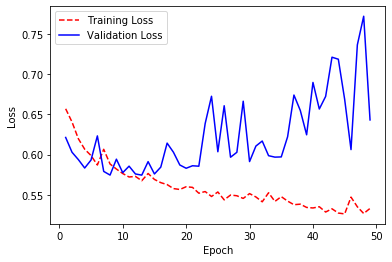

In [177]:
plot_loss_history(lstm_history)

In [178]:
def output_consumer(predictions,threshold):
#     print(predictions.shape)
    flattened_pred=predictions.ravel()
#     print(flattened_pred.shape)
    results=[0 if x<threshold else 1 for x in flattened_pred]
    return np.array(results)

In [179]:
# Now load the saved best model to use for inference
lstm_model.load_weights(saved_model_path)
predictions = lstm_model.predict(Xtest_scaled)
print(predictions.shape)

(376, 1)


In [180]:
threshold=0.5
test_outputs=output_consumer(predictions,threshold)
test_outputs=test_outputs.ravel()
ytest=ytest.ravel()
print(test_outputs.shape)
print(ytest.shape)

(376,)
(376,)


Accuracy: 0.6117021276595744; Precision: 0.6020408163265306; Recall: 0.8592233009708737
[[ 53 117]
 [ 29 177]]


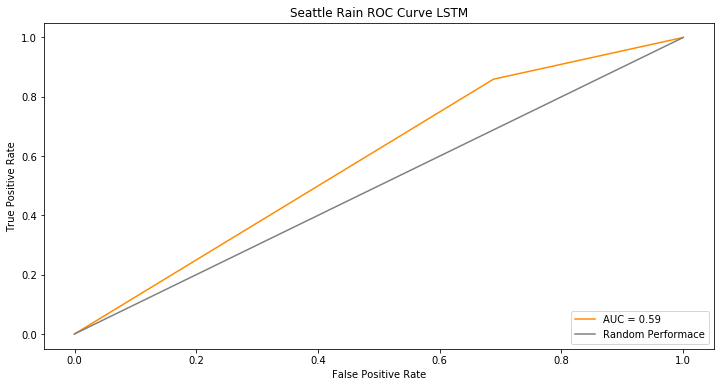

In [181]:
# evaluate performance
acc = metrics.accuracy_score(ytest,test_outputs)
precision_score = metrics.precision_score(ytest,test_outputs)
recall_score = metrics.recall_score(ytest,test_outputs)
print('Accuracy: {}; Precision: {}; Recall: {}'.format(acc,precision_score,recall_score))
print(metrics.confusion_matrix(ytest,test_outputs))
plot_roc(ytest,test_outputs,'LSTM')

#### Looks like both validation and test sets are performing okay with a vanilla LSTM, but it is actually worse than Random Forest Classifier or even just Naive Bayes. <br> Let's make the model a bit more complicated to see if the performance improves.

### Method 2: stacked LSTM

In [196]:
# Build stacked LSTM model
stacked_lstm_model = tf.keras.Sequential()
stacked_lstm_model.add(tf.keras.layers.LSTM(50, activation='relu', input_shape=(Xtrain_scaled.shape[1], Xtrain_scaled.shape[2]),return_sequences=True))
stacked_lstm_model.add(tf.keras.layers.LSTM(20, activation='relu'))
stacked_lstm_model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
stacked_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
stacked_lstm_model.summary()

Model: "sequential_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_15 (LSTM)               (None, 7, 50)             13400     
_________________________________________________________________
lstm_16 (LSTM)               (None, 20)                5680      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 21        
Total params: 19,101
Trainable params: 19,101
Non-trainable params: 0
_________________________________________________________________


In [197]:
saved_model_path=os.path.join(os.getcwd(),'stackedLSTM.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_model_path,
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True,
        verbose=1
    )

In [198]:
stacked_lstm_history = stacked_lstm_model.fit(Xtrain_scaled,ytrain, epochs=50, validation_data=(Xval_scaled,yval), shuffle=True, callbacks=[model_checkpoint_callback])

Train on 1126 samples, validate on 376 samples
Epoch 1/50
1120/1126 [============================>.] - ETA: 0s - loss: 0.6753 - accuracy: 0.5821
Epoch 00001: val_loss improved from inf to 0.65245, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/stackedLSTM.hdf5
1126/1126 [==============================] - 3s 2ms/sample - loss: 0.6745 - accuracy: 0.5835 - val_loss: 0.6524 - val_accuracy: 0.6330
Epoch 2/50
 960/1126 [========================>.....] - ETA: 0s - loss: 0.6615 - accuracy: 0.5813
Epoch 00002: val_loss improved from 0.65245 to 0.64935, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/stackedLSTM.hdf5
1126/1126 [==============================] - 0s 265us/sample - loss: 0.6569 - accuracy: 0.5879 - val_loss: 0.6494 - val_accuracy: 0.6330
Epoch 3/50
1024/1126 [==========================>...] - ETA: 0s - loss: 0.6498 - accuracy: 0.6270
Epoch 00003: val_loss improved from 0.64935 to 0.64229, saving model to /Users/tinawang/ml_experiment

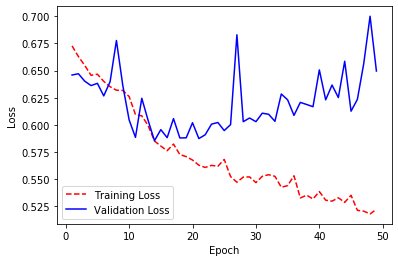

In [185]:
plot_loss_history(stacked_lstm_history)

In [186]:
# Now load the saved best model to use for inference
stacked_lstm_model.load_weights(saved_model_path)
predictions = stacked_lstm_model.predict(Xtest_scaled)

In [187]:
threshold=0.5
test_outputs=output_consumer(predictions,threshold)
test_outputs=test_outputs.ravel()
ytest=ytest.ravel()
print(test_outputs.shape)
print(ytest.shape)

(376,)
(376,)


Accuracy: 0.6648936170212766; Precision: 0.6515151515151515; Recall: 0.8349514563106796
[[ 78  92]
 [ 34 172]]


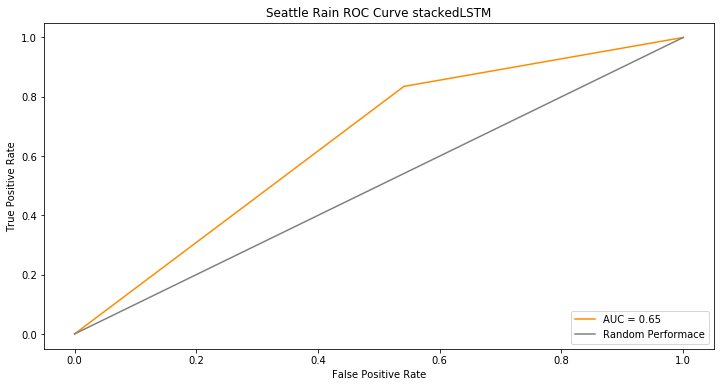

In [188]:
# evaluate performance
acc = metrics.accuracy_score(ytest,test_outputs)
precision_score = metrics.precision_score(ytest,test_outputs)
recall_score = metrics.recall_score(ytest,test_outputs)
print('Accuracy: {}; Precision: {}; Recall: {}'.format(acc,precision_score,recall_score))
print(metrics.confusion_matrix(ytest,test_outputs))
plot_roc(ytest,test_outputs,'stackedLSTM')

Addding more layers does seem to help on the performance. But can we do better?

### Method 3:  CNN

In [263]:
# Build CNN model
cnn_model = tf.keras.Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(Xtrain_scaled.shape[1], Xtrain_scaled.shape[2])))
cnn_model.add(MaxPool1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(1,activation='sigmoid'))
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_22 (Conv1D)           (None, 5, 64)             3136      
_________________________________________________________________
max_pooling1d_19 (MaxPooling (None, 2, 64)             0         
_________________________________________________________________
flatten_17 (Flatten)         (None, 128)               0         
_________________________________________________________________
dense_46 (Dense)             (None, 50)                6450      
_________________________________________________________________
dense_47 (Dense)             (None, 1)                 51        
Total params: 9,637
Trainable params: 9,637
Non-trainable params: 0
_________________________________________________________________


In [264]:
saved_model_path=os.path.join(os.getcwd(),'CNN.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_model_path,
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True,
        verbose=1
    )

In [265]:
cnn_history = cnn_model.fit(Xtrain_scaled,ytrain, epochs=50, validation_data=(Xval_scaled,yval), shuffle=True, callbacks=[model_checkpoint_callback])

Train on 1126 samples, validate on 376 samples
Epoch 1/50
 992/1126 [=========================>....] - ETA: 0s - loss: 0.6695 - accuracy: 0.5887 
Epoch 00001: val_loss improved from inf to 0.64338, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/CNN.hdf5
1126/1126 [==============================] - 1s 489us/sample - loss: 0.6678 - accuracy: 0.5897 - val_loss: 0.6434 - val_accuracy: 0.6303
Epoch 2/50
 864/1126 [======================>.......] - ETA: 0s - loss: 0.6557 - accuracy: 0.6215
Epoch 00002: val_loss improved from 0.64338 to 0.64028, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/CNN.hdf5
1126/1126 [==============================] - 0s 91us/sample - loss: 0.6527 - accuracy: 0.6243 - val_loss: 0.6403 - val_accuracy: 0.6250
Epoch 3/50
 768/1126 [===================>..........] - ETA: 0s - loss: 0.6501 - accuracy: 0.6198
Epoch 00003: val_loss improved from 0.64028 to 0.63567, saving model to /Users/tinawang/ml_experiments/new_york_rai

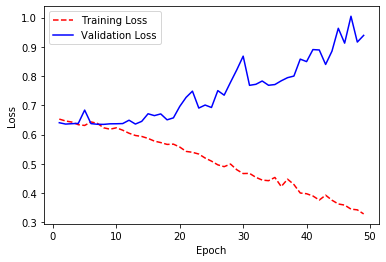

In [266]:
plot_loss_history(cnn_history)

In [267]:
# Now load the saved best model to use for inference
cnn_model.load_weights(saved_model_path)
predictions = cnn_model.predict(Xtest_scaled)

In [268]:
threshold=0.5
test_outputs=output_consumer(predictions,threshold)
test_outputs=test_outputs.ravel()
ytest=ytest.ravel()
print(test_outputs.shape)
print(ytest.shape)

(376,)
(376,)


Accuracy: 0.6382978723404256; Precision: 0.6268115942028986; Recall: 0.8398058252427184
[[ 67 103]
 [ 33 173]]


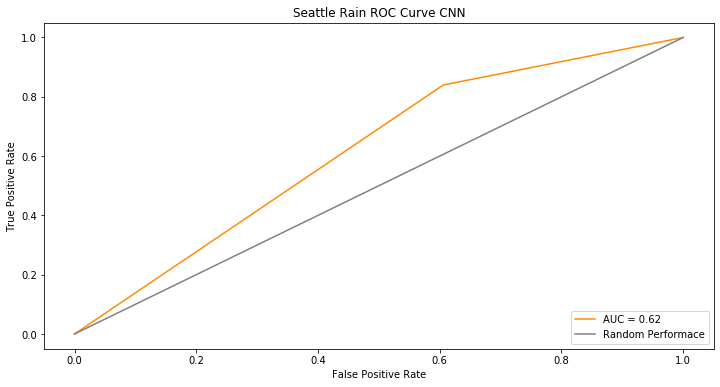

In [269]:
# evaluate performance
acc = metrics.accuracy_score(ytest,test_outputs)
precision_score = metrics.precision_score(ytest,test_outputs)
recall_score = metrics.recall_score(ytest,test_outputs)
print('Accuracy: {}; Precision: {}; Recall: {}'.format(acc,precision_score,recall_score))
print(metrics.confusion_matrix(ytest,test_outputs))
plot_roc(ytest,test_outputs,'CNN')

### Method 4: CNN+LSTM

In [288]:
cnn_lstm_model = tf.keras.Sequential()
cnn_lstm_model.add(Conv1D(filters=64, kernel_size=3, activation='relu',input_shape=(Xtrain_scaled.shape[1], Xtrain_scaled.shape[2])))
cnn_lstm_model.add(MaxPool1D(pool_size=2))
# cnn_lstm_model.add(Flatten())
cnn_lstm_model.add(LSTM(50, return_sequences=True))
cnn_lstm_model.add(LSTM(30))
cnn_lstm_model.add(Dense(1, activation='sigmoid'))
cnn_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_lstm_model.summary()

Model: "sequential_36"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_27 (Conv1D)           (None, 5, 64)             3136      
_________________________________________________________________
max_pooling1d_24 (MaxPooling (None, 2, 64)             0         
_________________________________________________________________
lstm_25 (LSTM)               (None, 2, 50)             23000     
_________________________________________________________________
lstm_26 (LSTM)               (None, 30)                9720      
_________________________________________________________________
dense_52 (Dense)             (None, 1)                 31        
Total params: 35,887
Trainable params: 35,887
Non-trainable params: 0
_________________________________________________________________


In [289]:
saved_model_path=os.path.join(os.getcwd(),'CNN_LSTM_D.hdf5')
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=saved_model_path,
        save_best_only=True,
        monitor='val_loss',
        save_weights_only=True,
        verbose=1
    )

In [290]:
cnn_lstm_history = cnn_lstm_model.fit(Xtrain_scaled,ytrain, epochs=50, validation_data=(Xval_scaled,yval), shuffle=True, callbacks=[model_checkpoint_callback])

Train on 1126 samples, validate on 376 samples
Epoch 1/50
1088/1126 [===========================>..] - ETA: 0s - loss: 0.6780 - accuracy: 0.5818
Epoch 00001: val_loss improved from inf to 0.65255, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/CNN_LSTM_D.hdf5
1126/1126 [==============================] - 4s 4ms/sample - loss: 0.6775 - accuracy: 0.5826 - val_loss: 0.6525 - val_accuracy: 0.6330
Epoch 2/50
1088/1126 [===========================>..] - ETA: 0s - loss: 0.6700 - accuracy: 0.5827
Epoch 00002: val_loss improved from 0.65255 to 0.64897, saving model to /Users/tinawang/ml_experiments/new_york_rain_prediction/CNN_LSTM_D.hdf5
1126/1126 [==============================] - 0s 186us/sample - loss: 0.6692 - accuracy: 0.5853 - val_loss: 0.6490 - val_accuracy: 0.6383
Epoch 3/50
1088/1126 [===========================>..] - ETA: 0s - loss: 0.6510 - accuracy: 0.6131
Epoch 00003: val_loss did not improve from 0.64897
1126/1126 [==============================] - 0s 185u

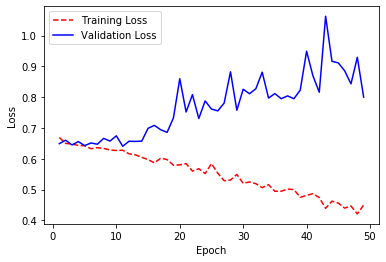

In [296]:
plot_loss_history(cnn_lstm_history)

In [297]:
# Now load the saved best model to use for inference
cnn_lstm_model.load_weights(saved_model_path)
predictions = cnn_lstm_model.predict(Xtest_scaled)

In [298]:
threshold=0.5
test_outputs=output_consumer(predictions,threshold)
test_outputs=test_outputs.ravel()
ytest=ytest.ravel()
print(test_outputs.shape)
print(ytest.shape)

(376,)
(376,)


Accuracy: 0.6329787234042553; Precision: 0.6214285714285714; Recall: 0.8446601941747572
[[ 64 106]
 [ 32 174]]


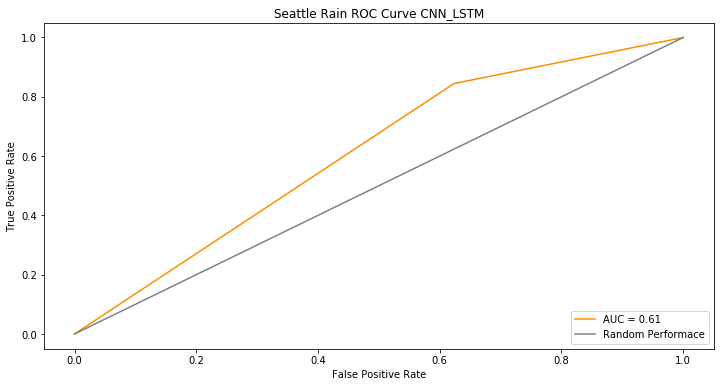

In [294]:
# evaluate performance
acc = metrics.accuracy_score(ytest,test_outputs)
precision_score = metrics.precision_score(ytest,test_outputs)
recall_score = metrics.recall_score(ytest,test_outputs)
print('Accuracy: {}; Precision: {}; Recall: {}'.format(acc,precision_score,recall_score))
print(metrics.confusion_matrix(ytest,test_outputs))
plot_roc(ytest,test_outputs,'CNN_LSTM')